In [71]:
import cv2
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
from cv2 import aruco
import matplotlib.pyplot as plt
import os
import polars as pl
import toml
import sys
from tqdm import tqdm
sys.path.append(os.path.join(os.getcwd(), ".."))
from support.pd_support import *

from datetime import datetime
from support.pd_support import *
from support.ar_calculations import *
from ultralytics import YOLO
from scipy.spatial.transform import Rotation as R

In [72]:
_base_pth = os.path.join(os.getcwd(), "recordings")
_folder_name = "yolo_v3_rpi_random_t0"
_video_pth = os.path.join(_base_pth, _folder_name, "webcam_color.msgpack")
_timestamp_pth = os.path.join(_base_pth, _folder_name, "webcam_timestamp.msgpack")

model = YOLO(r"E:\CMC\pyprojects\DeepVision\models_save\mip_ar_200e_noise.pt")

In [73]:
calib_data = toml.load("calibration.toml")
camera_mat = np.array(calib_data["calibration"]["camera_matrix"]).reshape((3, 3))
dist_coef = np.array(calib_data["calibration"]["dist_coeffs"]).reshape((1, 5))

In [74]:
with open(_timestamp_pth, "rb") as f:
    timestamps = list(mp.Unpacker(f, object_hook=mpn.decode))
    
with open(_video_pth, "rb") as f:
    video_data = list(mp.Unpacker(f, object_hook=mpn.decode))
    
_time = [datetime.strptime(_t, "%Y-%m-%d %H:%M:%S.%f") for _t in np.array(timestamps)[:, 1]]
_sync = np.array(timestamps)[:, 0].astype(bool)

In [75]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_MIP_36H12)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)


def estimatePoseSingleMarkers(corners, marker_size, mtx, distortion):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    trash = []
    rvecs = []
    tvecs = []
    for c in corners:
        nada, R, t = cv2.solvePnP(
            marker_points, c, mtx, distortion, True, flags=cv2.SOLVEPNP_ITERATIVE
        )

        if not (R is None or t is None):
            R = np.array(R).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()

        rvecs.append(R)
        tvecs.append(t)
    return rvecs, tvecs

In [76]:
data = {"frame_id": [], "marker_ids": [], "corners": [], "tvec": [], "rvec": []}
counter = 0

for _frame in tqdm(video_data):
    _frame = cv2.cvtColor(_frame, cv2.COLOR_RGBA2RGB)
    yolo_results = model.predict(_frame, verbose=False, imgsz=640, conf=0.8)[0]
    modelcorners = []
    for _keys in yolo_results.keypoints.data:
        modelcorners.append(_keys[0:4].cpu().numpy())
    modelcorners = np.array(modelcorners)
    corners = modelcorners
    if (
        len(yolo_results.boxes.cls.cpu().numpy()) != 0
    ):  # if there are any detections else None
        _idx = yolo_results.boxes.cls.cpu().numpy()
        ids = []
        for i in _idx:
            match i:
                case 0:
                    ids.append([12])
                case 1:
                    ids.append([88])
                case 2:
                    ids.append([89])
        ids = np.array(ids, dtype=np.int32)
    else:
        ids = None


    if ids is None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(None)
        data["corners"].append(None)
        data["tvec"].append(None)
        data["rvec"].append(None)

    if ids is not None:
        rvec, tvec = estimatePoseSingleMarkers(
            corners=corners,
            marker_size=0.05,
            mtx=camera_mat,
            distortion=dist_coef,
        )
        data["frame_id"].append(counter)
        data["marker_ids"].append(ids)
        data["corners"].append(corners)
        data["tvec"].append(tvec)
        data["rvec"].append(rvec)
    counter += 1

100%|██████████| 2873/2873 [00:45<00:00, 63.05it/s]


In [77]:
default_ids = [12, 14, 20, 88, 89]
coordinate = {
    str(id): {"x": [], "y": [], "z": [], "rx": [], "ry": [], "rz": []}
    for id in default_ids
}

for i, frame_id in enumerate(data["frame_id"]):
    if data["marker_ids"][i] is not None:
        existing_ids = set(data["marker_ids"][i].reshape(-1))
        missing_ids = set(default_ids) - existing_ids

        for _m, tvec, rvec in zip(
            data["marker_ids"][i], data["tvec"][i], data["rvec"][i]
        ):
            if _m in default_ids:
                coord = coordinate[str(_m[0])]
                coord["x"].append(tvec[0][0])
                coord["y"].append(tvec[0][1])
                coord["z"].append(tvec[0][2])
                coord["rx"].append(rvec[0][0])
                coord["ry"].append(rvec[0][1])
                coord["rz"].append(rvec[0][2])

        for _m in missing_ids:
            coord = coordinate[str(_m)]
            coord["x"].append(np.nan)
            coord["y"].append(np.nan)
            coord["z"].append(np.nan)
            coord["rx"].append(np.nan)
            coord["ry"].append(np.nan)
            coord["rz"].append(np.nan)
    else:
        for _m in default_ids:
            coord = coordinate[str(_m)]
            coord["x"].append(np.nan)
            coord["y"].append(np.nan)
            coord["z"].append(np.nan)
            coord["rx"].append(np.nan)
            coord["ry"].append(np.nan)
            coord["rz"].append(np.nan)

In [78]:
ar_df = pl.from_dicts(coordinate["88"])
rvec = ar_df[["rx", "ry", "rz"]][0].to_numpy()
ar_rotmat = cv2.Rodrigues(rvec)[0]

tar = ar_rotmat.T @ (
    ar_df[["x", "y", "z"]].to_numpy().T - ar_df[["x", "y", "z"]][0].to_numpy().T
)
_ar_df = pl.from_dicts({"time": _time, "x": tar[0], "y": tar[1], "z": tar[2]})

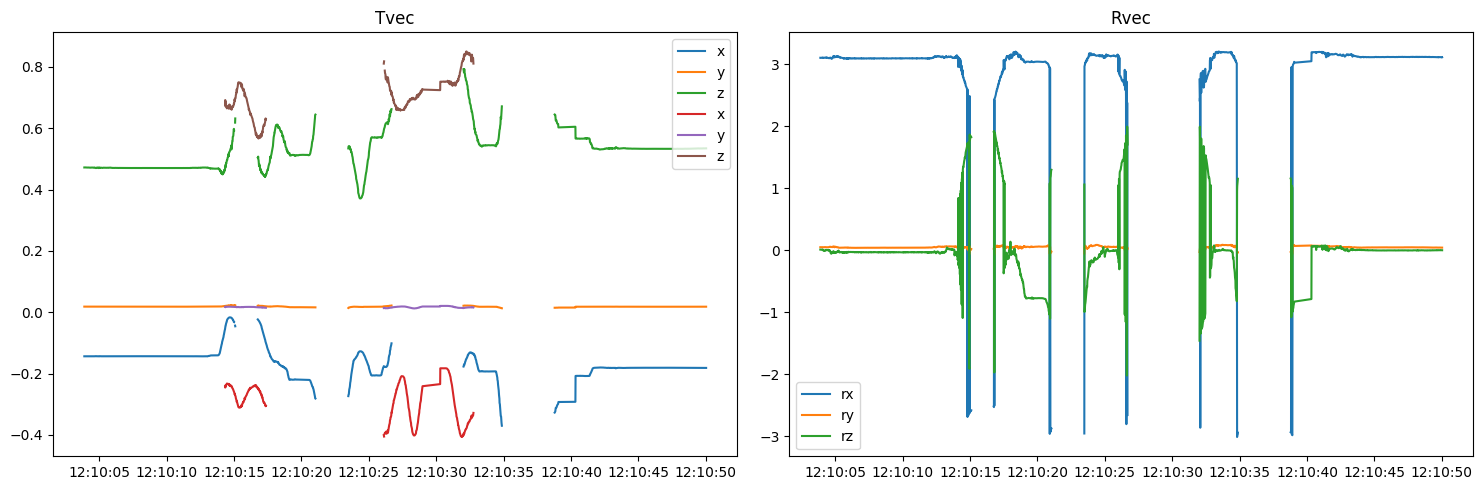

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(_ar_df["time"], coordinate['88']["x"], label="x")
ax1.plot(_ar_df["time"], coordinate['88']["y"], label="y")
ax1.plot(_ar_df["time"], coordinate['88']["z"], label="z")
ax1.plot(_ar_df["time"], coordinate['89']["x"], label="x")
ax1.plot(_ar_df["time"], coordinate['89']["y"], label="y")
ax1.plot(_ar_df["time"], coordinate['89']["z"], label="z")
ax1.set_title("Tvec")

ax1.set_title("Tvec")
ax1.legend()
ax2.plot(_ar_df["time"], coordinate["88"]["rx"], label="rx")
ax2.plot(_ar_df["time"], coordinate["88"]["ry"], label="ry")
ax2.plot(_ar_df["time"], coordinate["88"]["rz"], label="rz")
ax2.set_title("Rvec")
ax2.legend()
plt.tight_layout()
plt.show()


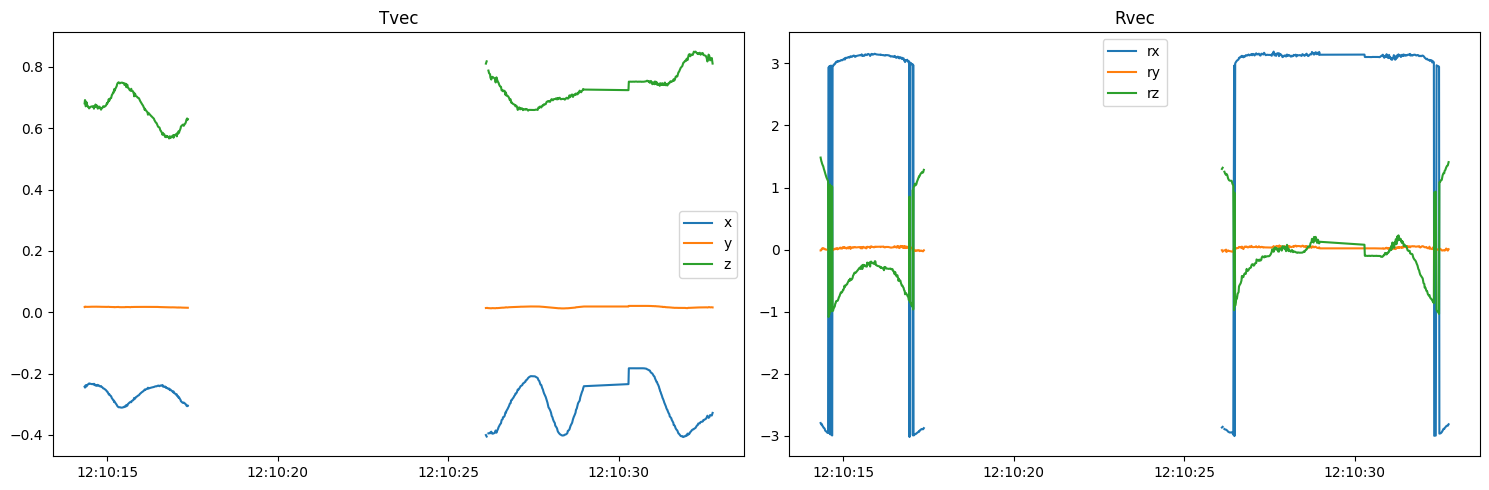

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(_ar_df["time"], coordinate['89']["x"], label="x")
ax1.plot(_ar_df["time"], coordinate['89']["y"], label="y")
ax1.plot(_ar_df["time"], coordinate['89']["z"], label="z")
ax1.set_title("Tvec")
ax1.legend()
ax2.plot(_ar_df["time"], coordinate["89"]["rx"], label="rx")
ax2.plot(_ar_df["time"], coordinate["89"]["ry"], label="ry")
ax2.plot(_ar_df["time"], coordinate["89"]["rz"], label="rz")
ax2.set_title("Rvec")
ax2.legend()
plt.tight_layout()
plt.show()


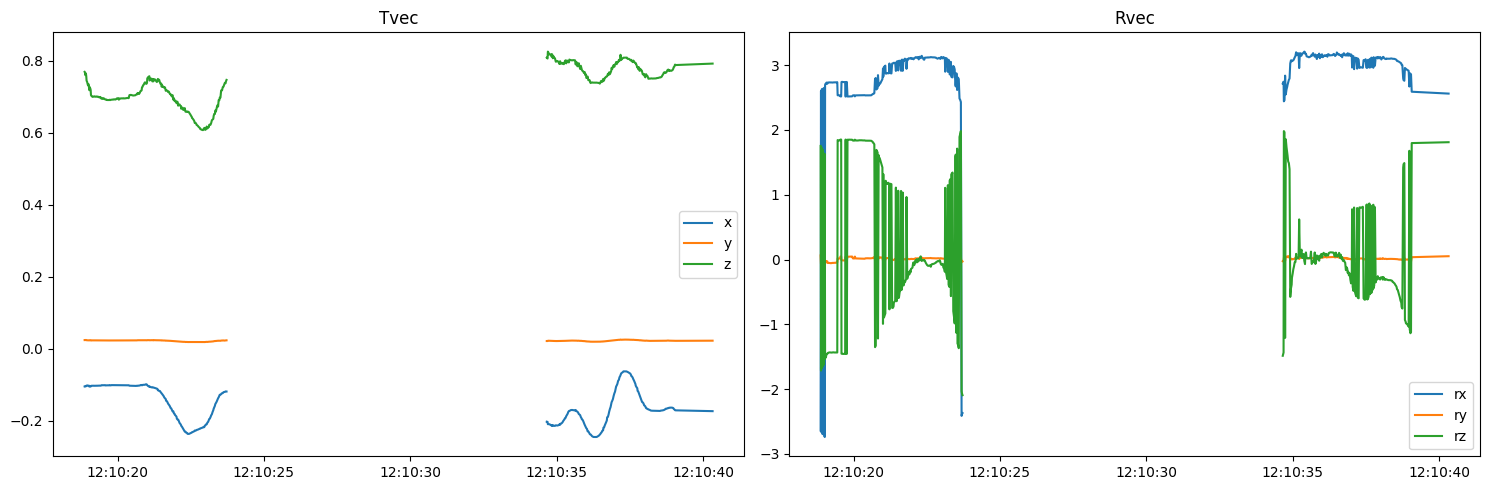

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(_ar_df["time"], coordinate['12']["x"], label="x")
ax1.plot(_ar_df["time"], coordinate['12']["y"], label="y")
ax1.plot(_ar_df["time"], coordinate['12']["z"], label="z")
ax1.set_title("Tvec")
ax1.legend()
ax2.plot(_ar_df["time"], coordinate["12"]["rx"], label="rx")
ax2.plot(_ar_df["time"], coordinate["12"]["ry"], label="ry")
ax2.plot(_ar_df["time"], coordinate["12"]["rz"], label="rz")
ax2.set_title("Rvec")
ax2.legend()
plt.tight_layout()
plt.show()


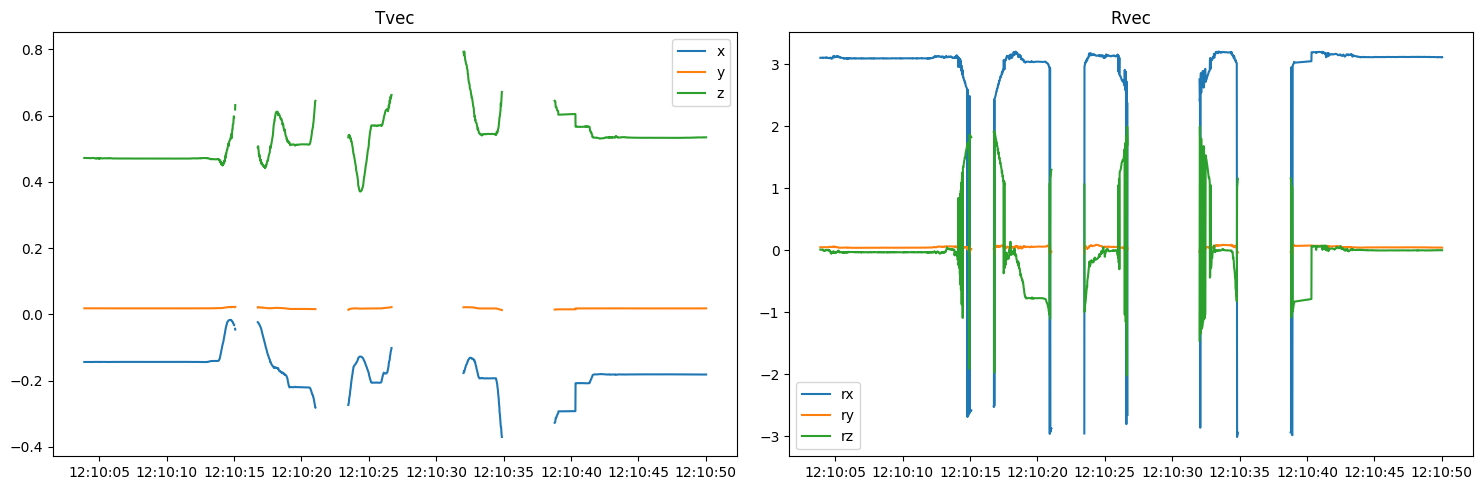

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(_ar_df["time"], coordinate['88']["x"], label="x")
ax1.plot(_ar_df["time"], coordinate['88']["y"], label="y")
ax1.plot(_ar_df["time"], coordinate['88']["z"], label="z")
ax1.set_title("Tvec")
ax1.legend()
ax2.plot(_ar_df["time"], coordinate["88"]["rx"], label="rx")
ax2.plot(_ar_df["time"], coordinate["88"]["ry"], label="ry")
ax2.plot(_ar_df["time"], coordinate["88"]["rz"], label="rz")
ax2.set_title("Rvec")
ax2.legend()
plt.tight_layout()
plt.show()


In [113]:
start_idx = list(_sync).index(1)
end_idx = start_idx + list(_sync[start_idx:]).index(0)
sync = _sync[start_idx:end_idx]
time = _time[start_idx:end_idx]
sync_start_time = time[0]
sync_end_time = time[-1]

_mocap_pth = os.path.join(_base_pth, 'mocap', _folder_name + '.csv')
mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
mocap_df = add_datetime_col(mocap_df, st_time, "seconds")
mocap_df = pl.from_pandas(mocap_df)

_mocap_quats = mocap_df[["rb_ang_x", "rb_ang_y", "rb_ang_z", "rb_ang_w"]].to_numpy()

_mocap_mat = R.from_quat(_mocap_quats[0]).as_matrix()
_time_offset = sync_start_time - mocap_df["time"][0]
mocap_df = mocap_df.with_columns([(pl.col("time") + _time_offset).alias("time")])

e:\CMC\pyprojects\DeepVision\wearable\..\support\pd_support.py:326: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  _rb_df = _rb_df.apply(pd.to_numeric, errors="ignore")


In [115]:
_m = get_rb_marker_name(6)
_m_org = mocap_df[[_m["x"], _m["y"], _m["z"]]][0].to_numpy().T
_m_tvec = mocap_df[[_m["x"], _m["y"], _m["z"]]].to_numpy().T
_m_transformed = _mocap_mat.T @ (_m_tvec - _m_org)

## Interpolating mocap orientation

In [117]:
from scipy.interpolate import interp1d

q_x = interp1d(mocap_df["time"].dt.epoch(), _mocap_quats[:,0], fill_value='extrapolate')
q_y = interp1d(mocap_df['time'].dt.epoch(), _mocap_quats[:,1], fill_value='extrapolate')
q_z = interp1d(mocap_df['time'].dt.epoch(), _mocap_quats[:,2], fill_value='extrapolate')
q_w = interp1d(mocap_df['time'].dt.epoch(), _mocap_quats[:,3], fill_value='extrapolate')

_iq_x = q_x(_ar_df['time'].dt.epoch())
_iq_y = q_y(_ar_df['time'].dt.epoch())
_iq_z = q_z(_ar_df['time'].dt.epoch())
_iq_w = q_w(_ar_df['time'].dt.epoch())

_mocap_iquats = np.array([_iq_x, _iq_y, _iq_z, _iq_w]).T

In [118]:
_mocap_rmats = []
for i in range(len(_mocap_iquats)):
    try:
        _mocap_rmats.append(R.from_quat(_mocap_iquats[i]).as_matrix())
    except:
        _mocap_rmats.append(np.eye(3))

In [168]:
_mocap_rmat_transform = []
inx = 10
ar_rmat_0 = R.from_rotvec([coordinate['88']['rx'][inx], coordinate['88']['ry'][inx], coordinate['88']['rz'][inx]]).as_matrix()
for _r in _mocap_rmats:
    _temp_r = ar_rmat_0 @ _r.T
    _mocap_rmat_transform.append(_temp_r.T)

In [169]:
# Define offsets

offsets = {
    12: np.array([-0.05, 0.03, -0.055]),
    14: np.array([0.00, 0.1025, -0.069]),
    20: np.array([0.00, 0.01, -0.069]),
    88: np.array([0.00, 0.03, -0.16]),
    89: np.array([0.05, 0.03, -0.055]),
}

# offsets = {
#     12: np.array([-0.09, 0.0, -0.069]),
#     14: np.array([0.00, 0.1025, -0.069]),
#     20: np.array([0.00, 0.01, -0.069]),
#     88: np.array([0.00, 0.0, -0.1075]),
#     89: np.array([0.1, 0.0, -0.055]),
# }

phi = np.pi / 2
positive_90_rotation = np.array(
    [[np.cos(phi), 0, np.sin(phi)], [0, 1, 0], [-np.sin(phi), 0, np.cos(phi)]]
)

negative_90_rotation = np.array(
    [[np.cos(-phi), 0, np.sin(-phi)], [0, 1, 0], [-np.sin(-phi), 0, np.cos(-phi)]]
)


# Function to compute transformed coordinates
def compute_transformed_coordinates(coordinate, id_offset, id):
        
    if id == 89:
        rotation_matrix = [_r @ negative_90_rotation for _r in _mocap_rmat_transform]
    elif id == 12:
        rotation_matrix = [_r @ positive_90_rotation for _r in _mocap_rmat_transform]
    else:
        rotation_matrix = _mocap_rmat_transform
        
    translation_vector = np.array([coordinate["x"], coordinate["y"], coordinate["z"]])
    transformed = np.array(
        [
            (_r @ id_offset.reshape(3, 1) + _t.reshape(3, 1)).T[0]
            for _r, _t in zip(rotation_matrix, translation_vector.T)
        ]
    )
    return rotation_matrix, translation_vector, transformed


# Compute transformations
results = {}
for key in offsets.keys():
    results[key] = compute_transformed_coordinates(coordinate[str(key)], offsets[key], key)

# Transform to global coordinates
_r_88_inv = results[88][0][0].T
_tvec_88_0 = results[88][2][0]

world_coordinates = {}
for key in offsets.keys():
    world_coordinates[key] = _r_88_inv @ (results[key][2] - _tvec_88_0).T

_gt_12, _gt_14, _gt_20, _gt_88, _gt_89 = [
    world_coordinates[key] for key in [12, 14, 20, 88, 89]
]
_mean_val = np.nanmean([_gt_12, _gt_14, _gt_20, _gt_88, _gt_89], axis=0)
# _mean_val = np.nanmean([_gt_88], axis=0)
# 
_mean_val = _mean_val.T[start_idx:end_idx]



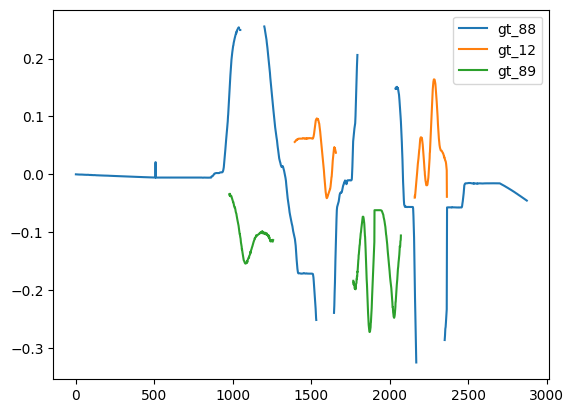

In [170]:
plt.plot(_gt_88[0], label="gt_88")
plt.plot(_gt_12[0], label="gt_12")
plt.plot(_gt_89[0], label="gt_89")
plt.legend()

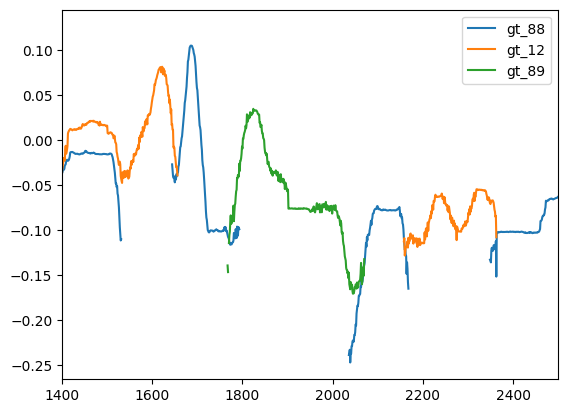

In [171]:
plt.plot(_gt_88[2], label="gt_88")
plt.plot(_gt_12[2], label="gt_12")
plt.plot(_gt_89[2], label="gt_89")
plt.xlim(1400, 2500)
plt.legend()

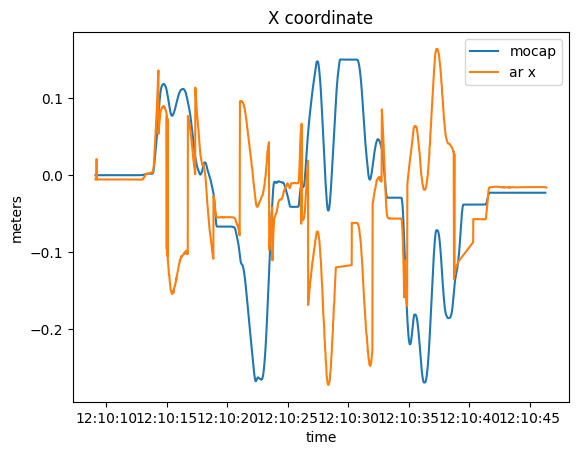

In [172]:
plt.plot(mocap_df["time"], _m_transformed[0], label="mocap")
plt.plot(time, _mean_val[:,0], label="ar x")
plt.xlabel("time")
plt.ylabel("meters")
plt.title("X coordinate")
plt.legend()

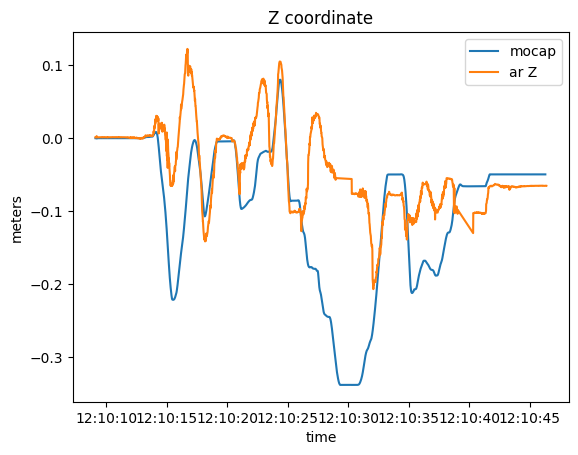

In [173]:
plt.plot(mocap_df["time"], _m_transformed[2], label="mocap")
plt.plot(time, _mean_val[:,2], label="ar Z")
plt.xlabel("time")
plt.ylabel("meters")
plt.title("Z coordinate")
plt.legend()